## **Implementing and Training an LSTM Network**

### Data Processing

In [73]:
import json
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from collections import Counter

In [74]:
max_reviews = 50000  # Limit to 100k reviews

data = []
with open('../data/dataset.json', 'r') as f:  # Replace with the path to your dataset
    for i, line in enumerate(f):
        if i == max_reviews:
            break
        data.append(json.loads(line))

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data)

In [75]:
# Combine sentences in `review_sentences` into a single string
df['review_text'] = df['review_sentences'].apply(lambda x: " ".join([sentence[1] for sentence in x]))

In [76]:
print(df.head())

                            user_id   timestamp  \
0  8842281e1d1347389f2ab93d60773d4d  2017-08-30   
1  8842281e1d1347389f2ab93d60773d4d  2017-03-22   
2  8842281e1d1347389f2ab93d60773d4d  2017-03-20   
3  8842281e1d1347389f2ab93d60773d4d  2016-11-09   
4  8842281e1d1347389f2ab93d60773d4d  2016-04-25   

                                    review_sentences  rating  has_spoiler  \
0  [[0, This is a special book.], [0, It started ...       5         True   
1  [[0, Recommended by Don Katz.], [0, Avail for ...       3        False   
2  [[0, A fun, fast paced science fiction thrille...       3         True   
3  [[0, Recommended reading to understand what is...       0        False   
4  [[0, I really enjoyed this book, and there is ...       4         True   

    book_id                         review_id  \
0  18245960  dfdbb7b0eb5a7e4c26d59a937e2e5feb   
1     16981  a5d2c3628987712d0e05c4f90798eb67   
2  28684704  2ede853b14dc4583f96cf5d120af636f   
3  27161156  ced5675e55cd9d38a5247

In [77]:
# Extract text and labels
texts = df['review_text'].values
labels = df['has_spoiler'].astype(int).values

In [78]:
# Check class imbalance
class_counts = Counter(labels)
total_reviews = sum(class_counts.values())
for label, count in class_counts.items():
    percentage = (count / total_reviews) * 100
    print(f"Class {label} (Has spoiler: {bool(label)}): {count} reviews ({percentage:.2f}%)")

# Output imbalance
print("\nClass counts:")
print(class_counts)

Class 1 (Has spoiler: True): 3427 reviews (6.85%)
Class 0 (Has spoiler: False): 46573 reviews (93.15%)

Class counts:
Counter({np.int64(0): 46573, np.int64(1): 3427})


In [79]:
# Tokenize
tokenizer = Tokenizer(num_words=10000)  # Limit vocabulary to top 10k words
tokenizer.fit_on_texts(texts)

print(texts[0])

This is a special book. It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind. This is what I love about good science fiction - it pushes your thinking about where things can go. It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I've read. For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc. It is a book about science, and aliens. The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell. Though when it got to folding protons into 8 dimensions I think he was just making stuff up - interesting to think about though. But what would happen if our SETI stations received a message - if we found someone was out there - and the person monitoring and answering the signal on our side was disillusion

In [80]:
# Padding
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=200)

print(sequences[0])
print(padded_sequences[0])

[12, 8, 5, 730, 13, 7, 266, 395, 15, 36, 1, 69, 519, 98, 10, 1, 503, 519, 7, 266, 4, 68, 156, 98, 1, 192, 519, 2383, 29, 305, 12, 8, 41, 3, 39, 36, 76, 984, 557, 7, 3413, 160, 411, 36, 126, 108, 77, 139, 7, 8, 5, 2027, 7226, 3078, 2, 6668, 45, 228, 551, 3369, 99, 127, 7, 156, 10, 32, 5, 193, 81, 45, 128, 108, 172, 28, 15, 2991, 1, 6, 3369, 7493, 516, 49, 43, 323, 115, 6, 116, 656, 7, 8, 5, 13, 36, 984, 2, 2636, 1, 984, 1101, 10, 1, 13, 8, 2663, 228, 5, 13, 4715, 10, 7324, 2, 184, 2603, 20, 281, 20, 3, 105, 315, 112, 51, 7, 143, 4, 89, 1560, 7227, 3, 86, 24, 11, 32, 410, 469, 48, 156, 4, 86, 36, 112, 14, 41, 62, 335, 57, 294, 860, 5, 1450, 57, 90, 164, 253, 11, 46, 44, 2, 1, 256, 2, 7861, 1, 25, 294, 368, 11, 9, 171, 6, 1, 13, 11, 5, 124, 329, 3, 62, 30, 4, 86, 455, 1714, 4, 2664, 1743, 5057, 9, 8, 8519, 62, 26, 40, 30, 739, 126, 90, 62, 1519, 180, 3, 83, 30, 49, 1, 13, 1, 1167, 131, 1, 739, 7, 11, 5, 696, 81, 4, 998, 4483, 16, 75, 2, 80, 277, 41, 1598, 668, 131, 677, 18, 140, 4957, 2, 

In [81]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

### Model Creation

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [83]:
word_index = tokenizer.word_index    # get the word index
total_words = len(word_index) + 1

print(total_words)

79762


In [84]:
def build_lstm_model():
    model = Sequential()
    model.add(Embedding(total_words, 64))
    model.add(LSTM(32))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
   
    optimizer = Adam(learning_rate=0.001) 
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [85]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import keras

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []

        self.fig = plt.figure(figsize=(8, 4))  # Smaller figure size

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get("loss"))
        self.val_losses.append(logs.get("val_loss"))
        self.accuracy.append(logs.get("accuracy"))
        self.val_accuracy.append(logs.get("val_accuracy"))
        self.i += 1

        clear_output(wait=True)
        
        # Plot losses
        plt.figure(figsize=(8, 4))  # Smaller figure size
        
        # Subplot 1: Loss
        plt.subplot(1, 2, 1)
        plt.plot(self.x, self.losses, label="Train Loss")
        plt.plot(self.x, self.val_losses, label="Validation Loss")
        plt.title("Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        
        # Subplot 2: Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.x, self.accuracy, label="Train Accuracy")
        plt.plot(self.x, self.val_accuracy, label="Validation Accuracy")
        plt.title("Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        
        plt.tight_layout()
        plt.show()

In [86]:
from sklearn.utils import class_weight
import numpy as np

# Assuming y_train contains your target labels
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert the class weights into a dictionary
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

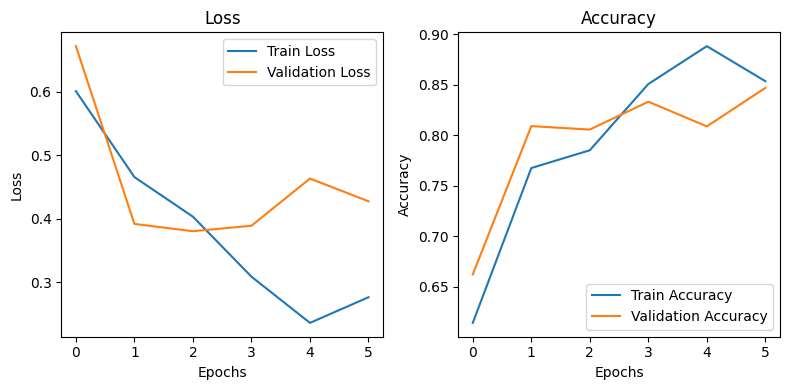

438/438 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.8240 - loss: 0.3030 - val_accuracy: 0.8471 - val_loss: 0.4276
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


In [87]:
plot_losses = PlotLosses()
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

model = build_lstm_model()

history = model.fit(
    X_train, y_train,
    validation_split=0.3,
    epochs=10,
    batch_size=64,
    verbose=1,
    class_weight=class_weight_dict,
    callbacks=[plot_losses,early_stopping]
)

In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 0.80
Precision: 0.17
Recall: 0.50
F1-score: 0.26


# **GRU Model**

In [89]:
from tensorflow.keras.layers import GRU

In [90]:
def build_gru_model():
    model = Sequential()
    model.add(Embedding(total_words, 64))
    model.add(GRU(32))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
   
    optimizer = Adam(learning_rate=0.001) 
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

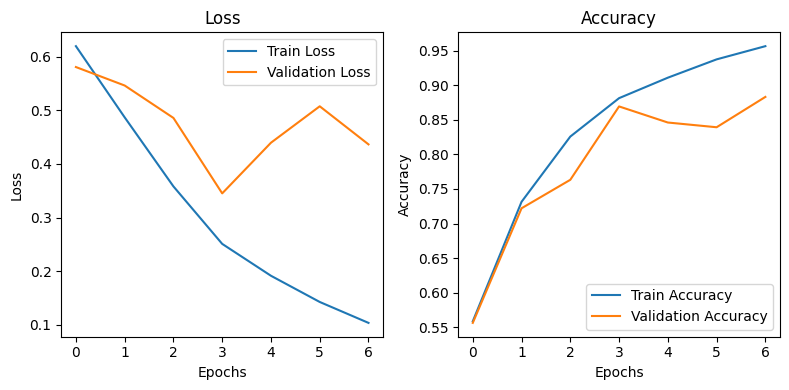

438/438 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.9597 - loss: 0.0921 - val_accuracy: 0.8830 - val_loss: 0.4366
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


In [91]:
plot_losses = PlotLosses()
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

gru_model = build_gru_model()

history = gru_model.fit(
    X_train, y_train,
    validation_split=0.3,
    epochs=10,
    batch_size=64,
    verbose=1,
    class_weight=class_weight_dict,
    callbacks=[plot_losses,early_stopping]
)

In [92]:
# Make predictions
y_pred = (gru_model.predict(X_test) > 0.5).astype("int32")

# Evaluate
accuracy_gru = accuracy_score(y_test, y_pred)
precision_gru = precision_score(y_test, y_pred)
recall_gru = recall_score(y_test, y_pred)
f1_gru = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy_gru:.2f}")
print(f"Precision: {precision_gru:.2f}")
print(f"Recall: {recall_gru:.2f}")
print(f"F1-score: {f1_gru:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Accuracy: 0.86
Precision: 0.18
Recall: 0.29
F1-score: 0.22


### **Model Comparison: GRU vs LSTM**
It is clear that the GRU model reduces the time complexity of model training whilst still maintaining presision. We can observe that accuracy also stayed relatively the same in comparison to the LSTM model.

The pros of the GRU model is the simplicity of the cell structure but maintaining the ability to forget and selectively remember certain parts of a sequence.

The pros of a LSTM model is the ability to handle and outperform GRU on more complex tasks which require increased granularity.

## Random Review Sampling and Prediction

In [93]:
import random

# Sample a random review
random_index = random.randint(0, len(df) - 1)
random_review = df.iloc[random_index]['review_text']
random_label = df.iloc[random_index]['has_spoiler']

# Preprocess the review
random_sequence = tokenizer.texts_to_sequences([random_review])
random_padded_sequence = pad_sequences(random_sequence, maxlen=200)

# Predict with both models
lstm_prediction = (model.predict(random_padded_sequence) > 0.5).astype("int32")[0][0]
gru_prediction = (gru_model.predict(random_padded_sequence) > 0.5).astype("int32")[0][0]

print(random_review)
print(f"Actual Label: {random_label}")
print(f"LSTM Prediction: {lstm_prediction}")
print(f"GRU Prediction: {gru_prediction}")

# Print if the predictions are correct or incorrect
print(f"LSTM Prediction: {'Correct' if lstm_prediction == random_label else 'Incorrect'}")
print(f"GRU Prediction: {'Correct' if gru_prediction == random_label else 'Incorrect'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
I've had this one on my list for a while and I am really glad I finally read it. I came home from the swim meet on Saturday just wrecked from the heat. I decided to sit on the couch near the AC vent for a bit and cool off. I picked up The Buddha in the Attic and didn't put it down again until I finished it. There may have been a teensy nap in there, but I think I read it in about 2 hours. In one of the most poignant histories I have ever read, Julie Otsuka uses the voices of all of the Japanese picture brides at once to tell their story. It was powerful. Telling about the women who came as picture brides to a place where nothing was as they expected. Telling how they worked to make a life for their children in a new land. Telling how that life was taken away unexpectedly by a war. Telling it from the point of view of hundreds of women. Unputdownable. Highly recommended. On the boat we were mostly virgins. We had

## Optimization Algorithm Comparison

In [94]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import numpy as np

In [95]:
optimizers = {
    "SGD": SGD(learning_rate=0.01),
    "SGD with Momentum": SGD(learning_rate=0.01, momentum=0.9),
    "RMSprop": RMSprop(learning_rate=0.001),
    "Adam": Adam(learning_rate=0.001)
}

In [96]:
def build_gru_model(optimizer):

    model = Sequential()
    model.add(Embedding(total_words, 64))
    model.add(GRU(32))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [97]:
results = {}

for optimizer_name, optimizer in optimizers.items():
    print(f"Training with {optimizer_name}...")
    
    model = build_gru_model(optimizer)
    
    start_time = time.time()
    
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    
    training_time = time.time() - start_time
    
    final_accuracy = history.history['accuracy'][-1]
    final_loss = history.history['loss'][-1]
    
    # Store results
    results[optimizer_name] = {
        'training_time': training_time,
        'final_accuracy': final_accuracy,
        'final_loss': final_loss,
        'epochs': len(history.history['loss']),
    }

# Display results in a table
import pandas as pd

results_df = pd.DataFrame(results).T
results_df = results_df[['training_time', 'final_accuracy', 'final_loss', 'epochs']]
results_df

Training with SGD...
Training with SGD with Momentum...
Training with RMSprop...
Training with Adam...


,training_time,final_accuracy,final_loss,epochs
SGD,187.579661,0.931425,0.252627,10.0
SGD with Momentum,190.500591,0.931425,0.247347,10.0
RMSprop,221.343723,0.950175,0.145569,10.0
Adam,213.525806,0.996100,0.014861,10.0


The best accuracy was achieved with Adam yet it was one of the slowest to train. However, the final loss is notably lower than other losses. We could say that the trade off between training time and accuracy makes sense in this case, because 99% vs 93% is a big difference, especially if applied to real world scenarios.